In [1]:
import numpy as np
import matplotlib.pyplot as plt

from pyomo.core.base.objective import minimize
from pyomo.environ import ConcreteModel, AbstractModel, Var, Objective, Constraint, ConstraintList, SolverFactory
from pyomo.environ import maximize, Binary, RangeSet, Set, NonNegativeReals, Reals

from utils import get_binary_string, neighboring_set, get_hydrophobic_set, calculate_offset, plot_folding, build_graph

In [2]:
protein_sequence = "HPHPHH"
protein_binary_sequence = get_binary_string(protein_sequence)

print("Protein sequence:", protein_sequence)
print("Protein binary sequence:", protein_binary_sequence)
n = len(protein_sequence)
print("Protein length:", n)

print("Offset: ", calculate_offset(protein_binary_sequence))

Protein sequence: HPHPHH
Protein binary sequence: 101011
Protein length: 6
Offset:  1


## Basic Model
This model is from the chapter 7 of the book

In [3]:
def ILP_basic_formulation(binary_seq):
    model = ConcreteModel()

    ###################
    #   VARIABLES     #
    ###################

    n = len(binary_seq) # sequence length
    grid_size = n*n
    offset = calculate_offset(binary_seq)

    # Set of indices
    model.I = RangeSet(0, n - 1)    # character in the sequence index
    model.I1 = RangeSet(0, n - 2)
    model.P = RangeSet(0, grid_size - 1)    # point on grid index
    model.H = Set(initialize=get_hydrophobic_set(binary_seq))   # set of indexes in sequence where value is 1 (hydrophobic)

    # Decision variables
    model.x = Var(model.I, model.P, within=Binary)
    model.h = Var(model.P, within=Binary)
    model.c = Var(model.P, model.P, within=Binary) 


    ###################
    #   CONSTRAINTS   #
    ###################

    model.constraints = ConstraintList()

    # Each amino acid in the sequence is assigned to exactly one point on the grid
    for i in model.I:
        model.constraints.add(expr = ( sum( model.x[i, p] for p in model.P ) == 1 ) )
    
    # Each point on the grid is assigned at most one amino acid in the sequence
    for i in model.I:
        for j in model.I:
            for p in model.P:
                if i != j:
                    model.constraints.add(expr = ( model.x[i, p] + model.x[j, p] <= 1 ) )
    
    # Adjacent amino acids in the sequence are assigned to neighboring points on the grid
    for i in model.I1:
        for p in model.P:
            model.constraints.add(expr = ( model.x[i, p] <= sum( model.x[i+1, q] for q in neighboring_set(p, n) ) ) )

    # Constraints to detect contacts, i.e. edges (p,q) on the grid where neighboring points p and q
    # have been assigned non-adiancent characters in the sequence with value 1
    for p in model.P:
        model.constraints.add(expr = ( model.h[p] == sum( model.x[i, p] for i in model.H ) ) )
    for p in model.P:
        for q in model.P:
            if p != q:
                model.constraints.add(expr = ( model.h[p] + model.h[q] >= 2*model.c[p, q] ) )

    
    ###################
    #   OBJECTIVE     #
    ###################
    model.obj = Objective(expr = ( sum( model.c[p, q] for p in model.P for q in model.P ) - offset ), sense = maximize)


    ###################
    #   SOLVER        #
    ###################
    sol = SolverFactory('gurobi').solve(model, tee=True)

    # CHECK SOLUTION STATUS

    # Get a JSON representation of the solution
    sol_json = sol.json_repn()

    if sol_json['Solver'][0]['Status'] == 'ok':
        print("Optimal solution value:", model.obj())
        print("\tValues of the decision variables:", [[model.x[i, p]() for p in model.P] for i in model.I]) 
    else:
        print('Error in solving the model')

    return [[model.x[i, p]() for p in model.P] for i in model.I]



x = ILP_basic_formulation(protein_binary_sequence)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-05-18
Read LP format model from file /var/folders/57/yk3w62md44z9m6ndy61mkkz80000gn/T/tmpiqtskaf2.pyomo.lp
Reading time = 0.00 seconds
x1549: 2563 rows, 1549 columns, 7157 nonzeros
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[arm])

CPU model: Apple M1 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 2563 rows, 1549 columns and 7157 nonzeros
Model fingerprint: 0x97655fa0
Variable types: 1 continuous, 1548 integer (1548 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 47.0000000
Presolve removed 1695 rows and 687 columns
Presolve time: 0.03s
Presolved: 868 rows, 862 columns, 3252 nonzeros
Variable types: 0 continuous, 862 integer (862 binary)

Root relaxation: objective 1.750000e+02, 

[18, 12, 13, 19, 20, 14]


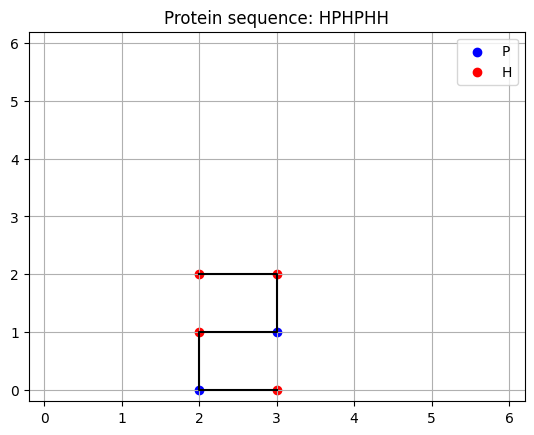

In [4]:
positions = []
pos = []
for i in range(len(x)):
    for p in range(len(x[i])):
        if x[i][p] == 1:
            positions.append((p // n, p % n))
            pos.append(p)
print(pos)

plot_folding(protein_binary_sequence, protein_sequence, positions, n)

## Graph Model
This model is from the paper

In [5]:
G = build_graph(protein_binary_sequence)
print(G.number_of_nodes(), G.number_of_edges())

print(G.edges())
m = G.number_of_edges()

model = ConcreteModel()
model.E = RangeSet(0, m-1)

x = []
for i in range(11):
    for j in range(11):
        try:
            for (u,v) in G[(i,j)]:
                x.append((u, v))
        except:
            pass
print(x)

for (u, v) in G[(6,6)]:
    print(u, v)

#for ((i, j), (u, v)) in G.edges():
    #print(i, j, u, v)


66 110
[((0, 0), (0, 1)), ((0, 1), (0, 2)), ((0, 1), (1, 1)), ((0, 2), (0, 3)), ((0, 2), (1, 2)), ((0, 3), (0, 4)), ((0, 3), (1, 3)), ((0, 4), (0, 5)), ((0, 4), (1, 4)), ((0, 5), (0, 6)), ((0, 5), (1, 5)), ((0, 6), (0, 7)), ((0, 6), (1, 6)), ((0, 7), (0, 8)), ((0, 7), (1, 7)), ((0, 8), (0, 9)), ((0, 8), (1, 8)), ((0, 9), (0, 10)), ((0, 9), (1, 9)), ((0, 10), (1, 10)), ((1, 1), (1, 2)), ((1, 2), (1, 3)), ((1, 2), (2, 2)), ((1, 3), (1, 4)), ((1, 3), (2, 3)), ((1, 4), (1, 5)), ((1, 4), (2, 4)), ((1, 5), (1, 6)), ((1, 5), (2, 5)), ((1, 6), (1, 7)), ((1, 6), (2, 6)), ((1, 7), (1, 8)), ((1, 7), (2, 7)), ((1, 8), (1, 9)), ((1, 8), (2, 8)), ((1, 9), (1, 10)), ((1, 9), (2, 9)), ((1, 10), (2, 10)), ((2, 2), (2, 3)), ((2, 3), (2, 4)), ((2, 3), (3, 3)), ((2, 4), (2, 5)), ((2, 4), (3, 4)), ((2, 5), (2, 6)), ((2, 5), (3, 5)), ((2, 6), (2, 7)), ((2, 6), (3, 6)), ((2, 7), (2, 8)), ((2, 7), (3, 7)), ((2, 8), (2, 9)), ((2, 8), (3, 8)), ((2, 9), (2, 10)), ((2, 9), (3, 9)), ((2, 10), (3, 10)), ((3, 3), (3

In [8]:
def ILP_graph_formulation(binary_seq, grid_size):
    model = ConcreteModel()

    ###################
    #   VARIABLES     #
    ###################

    n = len(binary_seq) # sequence length
    G = build_graph(binary_seq) # graph

    # Set of indices
    model.K = RangeSet(0, n - 1)    # set of indexes in sequence 
    model.K1 = RangeSet(0, n - 2)
    model.I = RangeSet(0, grid_size) 
    model.H = Set(initialize=get_hydrophobic_set(binary_seq))   # set of indexes in sequence where value is 1 (hydrophobic)

    # Decision Variables
    model.x = Var(model.K, model.I, model.I, within=Binary)
    model.y = Var(model.I, model.I, model.I, model.I, within=Binary)


    ###################
    #   CONSTRAINTS   #
    ###################

    model.constraints = ConstraintList()

    # the first amino acid is placed on the center of the grid (n,n)
    model.constraints.add(expr = ( model.x[0, n, n] == 1 ) )

    # each vertex has at most one amino acid
    for i in model.I:
        for j in model.I:
            model.constraints.add(expr = ( sum( model.x[k, i, j] for k in model.K ) <= 1 ) )
        
    # each amino acid is placed at exactly one vertex
    for k in model.K:
        model.constraints.add(expr = ( sum( model.x[k, i, j] for i in model.I for j in model.I ) == 1 ) )

    # if amino acid k is placed at (i, j) then amino acid k+1 is placed at a vertex (u, v) adjacent
    # to vertex (i, j)
    for k in model.K1:
        for i in model.I:
            for j in model.I:
                try:
                    model.constraints.add(expr = ( model.x[k, i, j] <= sum( model.x[k+1, u, v] for (u, v) in G[(i,j)] ) ) )
                except:
                    # if node is not in edges
                    pass
    

    # we want y[i, j ,u, v]=1 only if an H amino acid is placed at (i,j) and another amino acid H is placed at a neighboring vertex
    for ((i, j), (u, v)) in G.edges():
        model.constraints.add(expr = ( model.y[i, j, u, v] <= sum( model.x[k, i, j] for k in model.H ) ) )
        model.constraints.add(expr = ( model.y[i, j, u, v] <= sum( model.x[k, u, v] for k in model.H ) ) )

    ###################
    #   OBJECTIVE     #
    ###################
    model.obj = Objective(expr = ( sum( model.y[i, j, u, v] for ((i, j), (u, v)) in G.edges() ) ), sense = maximize)


    ###################
    #   SOLVER        #
    ###################
    sol = SolverFactory('gurobi').solve(model, tee=True)

    # CHECK SOLUTION STATUS

    # Get a JSON representation of the solution
    sol_json = sol.json_repn()

    if sol_json['Solver'][0]['Status'] == 'ok':
        print("Optimal solution value:", model.obj())
        print("\tValues of the decision variables:", ) 
    else:
        print('Error in solving the model')
    
    return [[[model.x[k, i, j]() for j in model.I] for i in model.I] for k in model.K]


grid_size = 2*n - 1
x = ILP_graph_formulation(protein_binary_sequence, grid_size)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-05-18
Read LP format model from file /var/folders/57/yk3w62md44z9m6ndy61mkkz80000gn/T/tmpyo0xjd58.pyomo.lp
Reading time = 0.00 seconds
x21601: 702 rows, 975 columns, 4260 nonzeros
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[arm])

CPU model: Apple M1 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 702 rows, 975 columns and 4260 nonzeros
Model fingerprint: 0x30c1c78b
Variable types: 1 continuous, 974 integer (974 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 1.0000000
Presolve removed 574 rows and 889 columns
Presolve time: 0.01s
Presolved: 128 rows, 86 columns, 378 nonzeros
Variable types: 0 continuous, 86 integer (86 binary)

Root relaxation: objective 3.666667e+00, 70 iteratio

[(6, 6), (6, 7), (5, 7), (4, 7), (4, 6), (5, 6)]


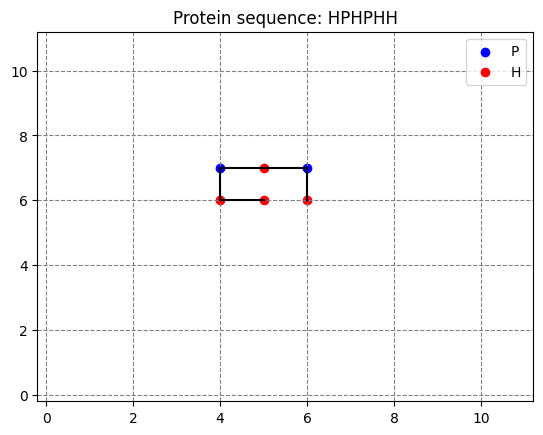

In [9]:
positions = []
for k in range(len(x)):
    for i in range(len(x[k])):
        for j in range(len(x[k][i])):
            if x[k][i][j] == 1:
                positions.append((i, j))
print(positions)

grid_size = 2*n - 1
plot_folding(protein_binary_sequence, protein_sequence, positions, grid_size)